In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization

from glob import glob

monet_path = ("gan-getting-started/monet_jpg")
photo_path = ("gan-getting-started/photo_jpg")

### Week 5: Monet Painting Generation

#### Problem
This project involves analyzing various paintings by Monet and creating an ML model that can modify photos to have a similar aesthetic as Monet's paintings. This data is sourced from https://www.kaggle.com/competitions/gan-getting-started/overview, containing 300 paintings by Monet, as well as various photos to try and stylize.

#### EDA
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

First, I'll take a look at the provided Monet images. There are 300 images total, all of them 256x256 images.

Total images:  300
Image sizes:  {(256, 256)}


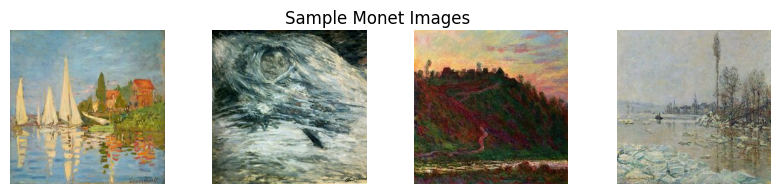

In [36]:
monet_images = glob(monet_path + "/*.jpg")

def image_sample(images, title):
    print("Total images: ", len(images))
    
    plt.figure(figsize=(10, 2))
    
    size_set = set()

    for image in images:
        img = load_img(image)
        size_set.add(img.size)
    
    for i, img_path in enumerate(images[:4]):
        img = load_img(img_path)    
        plt.subplot(1, 4, i + 1)  
        plt.imshow(img) 
        plt.axis('off')  
    
    plt.suptitle(f'Sample {title} Images') 
    
    print("Image sizes: ", size_set)
    
    plt.show()

image_sample(monet_images, "Monet")

I'll take a look at the Photos as well. There's 7038 total, all 256x256 images again, so I won't need to resize any images.

Total images:  7038
Image sizes:  {(256, 256)}


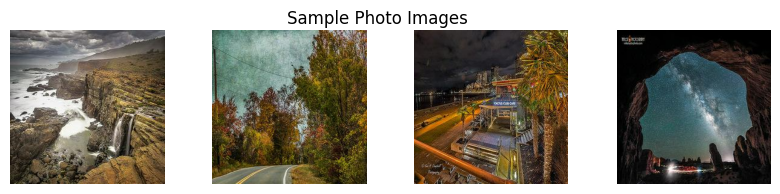

In [37]:
photo_images = glob(photo_path + "/*.jpg")
image_sample(photo_images, "Photo")

#### Model Architecture
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

In [ ]:
# Build Autoencoder

In [1]:
# Build Decoder

Building the generator component for the GAN. The goal is to take in random noise as an input, and then upsample into a 256x256x3 image as output.

In [44]:
# Build Generator
def build_gen(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),
    
        # Need to Upsample to 128x128    
        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (32, 32, 256) Shape

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (64, 64, 128)

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (128, 128, 64)

        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (256, 256, 32)

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')  # (256, 256, 3)
    ])
    return model

latent_dim = 100
generator = build_gen(latent_dim)
generator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32768)          │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 16, 16, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 32, 32, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 64, 64, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 128, 128, 32)   │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 256, 256, 3)    │         2,403 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,764,195 (29.62 MB)

 Trainable params: 7,697,699 (29.36 MB)

 Non-trainable params: 66,496 (259.75 KB)

Similarly, the discriminator needs to take in a 256x256x3 image, and determine if it's real or fake.

In [45]:
# Build Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid') 
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,314,753 (16.46 MB)

 Trainable params: 4,314,753 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

#### Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Copied from Week 4, might not apply.

#### Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?